# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from matplotlib.dates import DateFormatter
from matplotlib import dates
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
import warnings
import holidays
from scipy import stats
import calendar
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
warnings.filterwarnings('ignore')

## Graphical parameter setting

plot parameters initialization:

In [2]:
## parameter setting for graphs
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')

# Functions

In [3]:
## Adjust graph spines
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 20))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
            
### K fold target encoding for training test
class KFoldTargetEncoderTrain(BaseEstimator,TransformerMixin):

    def __init__(self, colnames,targetName,n_fold=5,verbosity=True,discardOriginal_col=False):

        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col

    def fit(self, X, y=None):
        return self


    def transform(self,X):

        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)

        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold, shuffle = False, random_state=2019)



        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan

        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]

            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)[self.targetName].mean())

        X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbosity:

            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,
                                                                                      self.targetName,
                                                                                      np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
            

        return(X)
    
### K Fold target encoding for test set
class KFoldTargetEncoderTest(BaseEstimator, TransformerMixin):
    
    def __init__(self,train,colNames,encodedName):
        
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        mean =  self.train[[self.colNames,
                self.encodedName]].groupby(
                                self.colNames).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]
        X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})
    
        return(X)

## correlation of multivariate analysis    
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    
## Traffic data feature manipulation
def lag1_mean(x): # traffic mean of the first 10 minutes 20 minutes prior to scheduled hour
    val = np.nan
    if x >=pd.Timestamp('2016-08-28 07:43:00'):
        val = traffic.loc[pd.date_range(x - pd.Timedelta("30min"),x - pd.Timedelta("20min"),freq ='min'),"Traffic.Ordinal"].mean(skipna = True)
    return(val)

def lag2_mean(x): # traffic mean of the second 10 minutes 20 minutes prior to scheduled hour
    val = np.nan
    if x >=pd.Timestamp('2016-08-28 07:43:00'):
        val = traffic.loc[pd.date_range(x - pd.Timedelta("40min"),x - pd.Timedelta("30min"),freq ='min'),"Traffic.Ordinal"].mean(skipna = True)
    return(val)

def lag3_mean(x): # traffic mean of the third 10 minutes 20 minutes prior to scheduled hour
    val = np.nan
    if x >=pd.Timestamp('2016-08-28 07:43:00'):
        val = traffic.loc[pd.date_range(x - pd.Timedelta("50min"),x - pd.Timedelta("40min"),freq ='min'),"Traffic.Ordinal"].mean(skipna = True)
    return(val)

def lag4_mean(x): # traffic mean of the fourth 10 minutes 20 minutes prior to scheduled hour
    val = np.nan
    if x >=pd.Timestamp('2016-08-28 07:53:00'):
        val = traffic.loc[pd.date_range(x - pd.Timedelta("60min"),x - pd.Timedelta("50min"),freq ='min'),"Traffic.Ordinal"].mean(skipna = True)
    return(val)


def lag1_sd(x):  # traffic standard deviation of the first 10 minutes 20 minutes prior to scheduled hour
    val = np.nan
    if x >=pd.Timestamp('2016-08-28 07:43:00'):
        val = traffic.loc[pd.date_range(x - pd.Timedelta("30min"),x - pd.Timedelta("20min"),freq ='min'),"Traffic.Ordinal"].std(skipna = True)
    return(val)

def lag2_sd(x):  # traffic standard deviation of the second 10 minutes 20 minutes prior to scheduled hour
    val = np.nan
    if x >=pd.Timestamp('2016-08-28 07:43:00'):
        val = traffic.loc[pd.date_range(x - pd.Timedelta("40min"),x - pd.Timedelta("30min"),freq ='min'),"Traffic.Ordinal"].std(skipna = True)
    return(val)

def lag3_sd(x):  # traffic standard deviation of the third 10 minutes 20 minutes prior to scheduled hour
    val = np.nan
    if x >=pd.Timestamp('2016-08-28 07:43:00'):
        val = traffic.loc[pd.date_range(x - pd.Timedelta("50min"),x - pd.Timedelta("40min"),freq ='min'),"Traffic.Ordinal"].std(skipna = True)
    return(val)

def lag4_sd(x):  # traffic standard deviation of the fourth 10 minutes 20 minutes prior to scheduled hour
    val = np.nan
    if x >=pd.Timestamp('2016-08-28 07:43:00'):
        val = traffic.loc[pd.date_range(x - pd.Timedelta("60min"),x - pd.Timedelta("50min"),freq ='min'),"Traffic.Ordinal"].std(skipna = True)
    return(val)

In [4]:
## load data
train = pd.read_csv("train_update.csv",index_col=0)
vancouver = pd.read_csv("vancouver_update.csv",index_col=0)
victoria = pd.read_csv("victoria_update.csv",index_col=0)
traffic = pd.read_csv("traffic_clean.csv",index_col=0)
test = pd.read_csv("test.csv",index_col=0)

## Data manipulation for Status<a class="tocSkip">
Since hyperparameter tuning is a time consuming process, we will take 7 steps to perform hyperparamter tuning by AUC: 
- Having different delay causes, we decided to reduce the cardinality of the category by combining similar levels.
- Remove the observations marked as delay that we did not have information to account for to remove noises.
- To maintain as much as information, we decided to retain the dealyed observations caused by traffic, operation, weather and mechanical issues.

In [7]:
## traffic delay
train.loc[train["Status"].isin(["Traffic delays","Ongoing traffic volume delay","Heavy traffic volume","Vessel congestion at berths","Traffic transfer delays"]),"Status"] = "Traffic delay"

## operational dely
train.loc[train["Status"].isin(["Operational delay","Operational Delay","Ongoing delay due to earlier operational delay"]),"Status"] = "Operational delay"

## weather delay
train.loc[train["Status"].isin(["Weather delays","Ongoing weather delays","Delays due to extreme weather"]),"Status"] = "Weather delay"

## Mechanical issue
train.loc[train["Status"].isin(["Mechanical difficulties with vessel","Mechanical difficulties with terminal equipment","Ongoing delays due to earlier mechanical issues"]),"Status"] = "Mechanical issue"

In [8]:
## Remove noisy observations because there are some subcategories that can not be predicted by our exisiting information.
train = train.loc[train["Status"].isin(["On Time","Traffic delay","Operational delay","Mechanical issue","Weather delay","High winds"]),:]
train.reset_index(drop = True,inplace = True)

In [10]:
test.reset_index(drop = True)
test["Delay.Indicator"] = np.nan

In [11]:
traffic.reset_index(inplace = True)
traffic.rename(columns = {"index":"Date"},inplace = True)
train["Day.of.Month"] = train["Day.of.Month"].astype("object")

# Exploratory data analysis

## Train

### Target encoding of major categorical variables

In [13]:
## Encode Vessel.Name
targetc = KFoldTargetEncoderTrain('Vessel.Name','Delay.Indicator',n_fold=5)
train = targetc.fit_transform(train)
test_targetc = KFoldTargetEncoderTest(train,
                                      'Vessel.Name',
                                      'Vessel.Name_Kfold_Target_Enc')
test = test_targetc.fit_transform(test)

## Encode Vessel.Name
targetc = KFoldTargetEncoderTrain('Trip','Delay.Indicator',n_fold=5)
train = targetc.fit_transform(train)
test_targetc = KFoldTargetEncoderTest(train,
                                     'Trip',
                                      'Trip_Kfold_Target_Enc')
test = test_targetc.fit_transform(test)

## Encode Day.of.Month
targetc = KFoldTargetEncoderTrain('Day.of.Month','Delay.Indicator',n_fold=5)
train = targetc.fit_transform(train)
test_targetc = KFoldTargetEncoderTest(train,
                                     'Day.of.Month',
                                      'Day.of.Month_Kfold_Target_Enc')
test = test_targetc.fit_transform(test)

Correlation between the new feature, Vessel.Name_Kfold_Target_Enc and, Delay.Indicator is 0.1564194255748473.
Correlation between the new feature, Trip_Kfold_Target_Enc and, Delay.Indicator is 0.1421846939416902.
Correlation between the new feature, Day.of.Month_Kfold_Target_Enc and, Delay.Indicator is -0.018482500621295833.



----------------Distribution of class label----------------



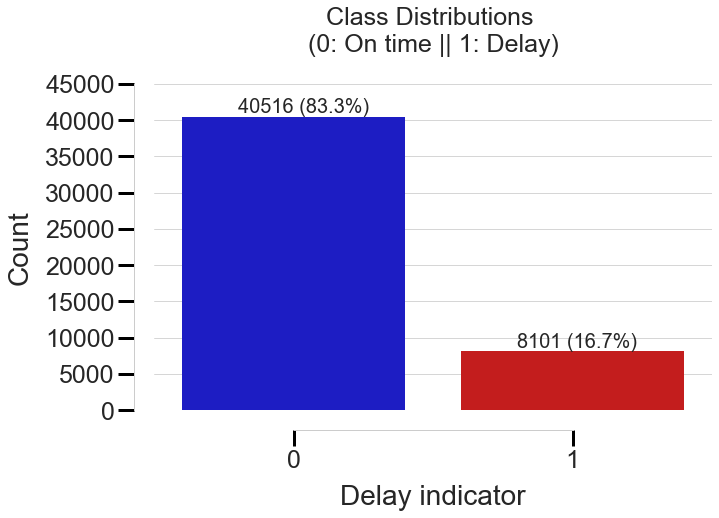

In [15]:
print('\n----------------Distribution of class label----------------\n')
plt.figure(figsize=(10,6))
colors = ["#0101DF", "#DF0101"]
ax = sns.countplot('Delay.Indicator', data=train, palette=colors)

total = len(train['Delay.Indicator'])
## set count and percentage labels above bars
for p in ax.patches:
        percentage = '{} ({:.1f}%)'.format(p.get_height(),100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/4 
        y = p.get_y() + p.get_height()+500
        ax.annotate(percentage, (x, y),size = 20)

ax.set_xlabel("Delay indicator",size = 28,labelpad=12)
ax.set_ylabel("Count",size = 28,labelpad=12)
ax.set_yticks([5000*i for i in range(10)])


ax.spines['bottom'].set_bounds(0, 1)
ax.tick_params(axis= "x",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.tick_params(axis= "y",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.set_title('Class Distributions \n (0: On time || 1: Delay) \n', fontsize=25)
adjust_spines(ax, ['left', 'bottom'])


plt.show()

### Important features extraction

Time related time variables **Month**,**Day**,**Weekend.Indicator**,**Holiday.Indicator** were derived as potential predicators and their predictive power will be evaluated.

In [58]:
## train: Feature extraction
train["Full.Date"] = pd.to_datetime(train["Full.Date"])
train["Month"]=pd.Series(pd.DatetimeIndex(train["Full.Date"]).month)
train["Day"] = train["Full.Date"].apply(lambda x: x.dayofweek)
train["weekend.Indicator"] = train["Day"]//5 ==1 

## test: Feature extraction
test.reset_index(inplace = True)
test["Full.Date"] = pd.to_datetime(test["Full.Date"])
test["Month"]=pd.Series(pd.DatetimeIndex(test["Full.Date"]).month)
test["Day"] = test["Full.Date"].apply(lambda x: x.dayofweek)
test["weekend.Indicator"] = test["Day"]//5 ==1 

In [59]:
## add a date column for train
train["Date_time"] = pd.to_datetime(train["Full.Date"].astype("str") +" "+ pd.to_datetime(train["Scheduled.Departure"]).apply(lambda x: x.strftime("%H:%M:%S")).astype("str"))
test["Date_time"] = pd.to_datetime(test["Full.Date"].astype("str") +" "+ pd.to_datetime(test["Scheduled.Departure"]).apply(lambda x: x.strftime("%H:%M:%S")).astype("str"))

## holiday indicator for train
train["holidays_indicator"] = train["Date_time"].apply(lambda x:x in holidays.CA())

## holiday indicator for test
test["holidays_indicator"] = test["Date_time"].apply(lambda x:x in holidays.CA())

### Number of sailings every day

In [60]:
sailings_train = train.loc[:,["Vessel.Name","Full.Date"]].groupby("Full.Date").count()
sailings_test = test.loc[:,["Vessel.Name","Full.Date"]].groupby("Full.Date").count()


train["Num.of.sailings"] = train["Full.Date"].apply(lambda x: sailings_train.loc[x,"Vessel.Name"])
test["Num.of.sailings"] = test["Full.Date"].apply(lambda x: sailings_test.loc[x,"Vessel.Name"])

#### Visualization of Year to the response

The target variable (**Delay indicator**) is not stratified by year.

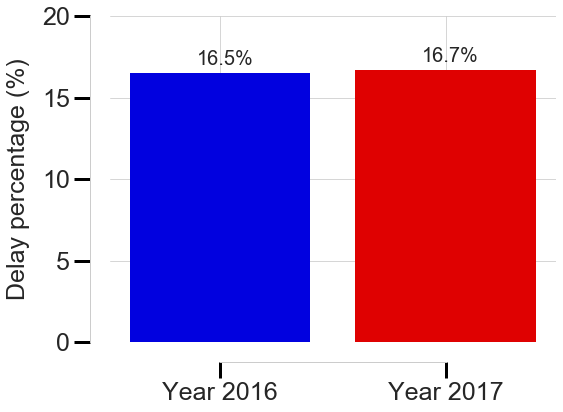

In [62]:
train_year = train[["Year","Delay.Indicator"]]
train_year = train_year.groupby("Year").mean().reset_index()
train_year['Year'] = train_year['Year'].astype('object')

fig, ax = plt.subplots(1,1,figsize=(8,6))

colors = ["#0101DF", "#DF0101"]
Year = [2016,2017]

Indicator = list(train_year["Delay.Indicator"].apply(lambda x: round(100*x,1)))
ax.bar(Year,Indicator,color = colors)

for p in ax.patches:
        percentage = '{}%'.format(p.get_height())
        x = p.get_x() + p.get_width()/2.7 
        y = p.get_y() + p.get_height()+0.5
        ax.annotate(percentage, (x, y),size = 20)

        
ax.set_xticks(Year)
ax.set_xticklabels(['Year 2016', 'Year 2017'])

ax.spines['bottom'].set_bounds(2016, 2017)

ax.tick_params(axis= "x",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.tick_params(axis= "y",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.set_ylabel("Delay percentage (%)",size = 25,labelpad=12)
ax.set_yticks([i for i in range(0,21,5)])
adjust_spines(ax, ['left', 'bottom'])

#### Visualization of Month related to the response

Vistially Month is a strong predictor because the Delay frequency varied from month to month ranging from 7.4% to 26.0%

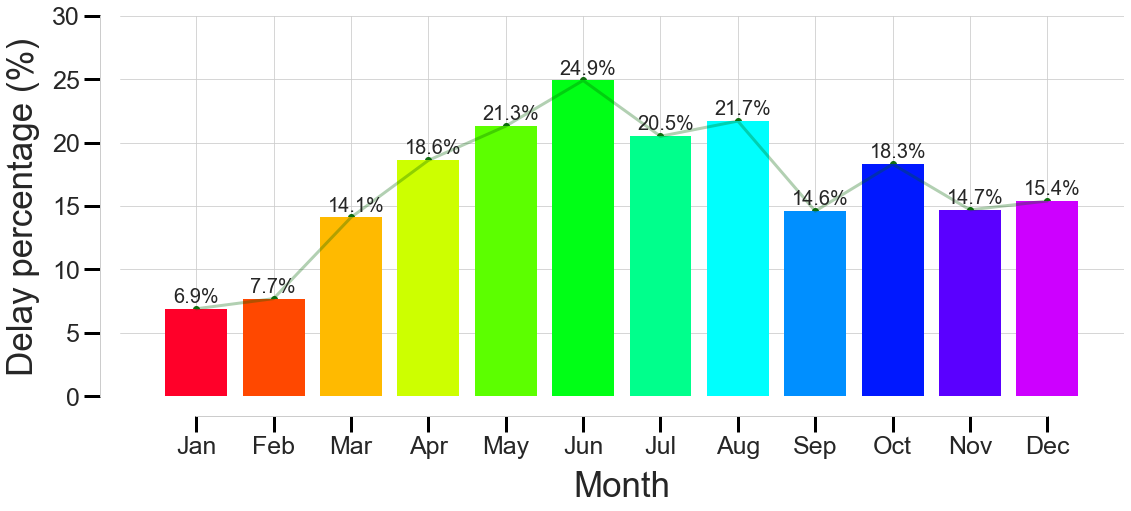

In [63]:
train_month = train[["Month","Delay.Indicator"]]
train_month = train_month.groupby("Month").mean().reset_index()
train_month['Month'] = train_month['Month'].astype('object')

fig, ax = plt.subplots(1,1,figsize=(18,7))
NUM_COLORS = 12
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

Month = train_month['Month']
Month_str = train_month['Month'].astype('int').apply(lambda x:calendar.month_abbr[x])
Indicator = list(train_month["Delay.Indicator"].apply(lambda x: round(x*100,1)))

ax.bar(Month,Indicator,color = colors)
ax.plot(Month,Indicator,alpha = 0.3,color = 'darkgreen',linewidth = "3")
ax.scatter(Month,Indicator,alpha = 0.9,color = 'darkgreen')
for p in ax.patches:
        percentage = '{}%'.format(p.get_height())
        x = p.get_x() + p.get_width()/8
        y = p.get_y() + p.get_height()+0.5
        ax.annotate(percentage, (x, y),size = 20)

ax.set_xticks(Month)
ax.set_xticklabels(Month_str)

ax.spines['bottom'].set_bounds(1,12)
ax.tick_params(axis= "x",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.tick_params(axis= "y",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.set_yticks([i for i in range(0,31,5)])
ax.set_ylabel("Delay percentage (%)",size = 35,labelpad=12)
ax.set_xlabel("Month",size = 35,labelpad=12)
adjust_spines(ax, ['left', 'bottom'])

#### Visualization of the response againts time

The delay rate varied from hour to hour and 00[24:00] has the highest delay percentage. However, after further investigation we noticed that there were merely 7 observations at time 00 which is too few to be representative of the category so we decided to combine it with the nearest time 23:00.

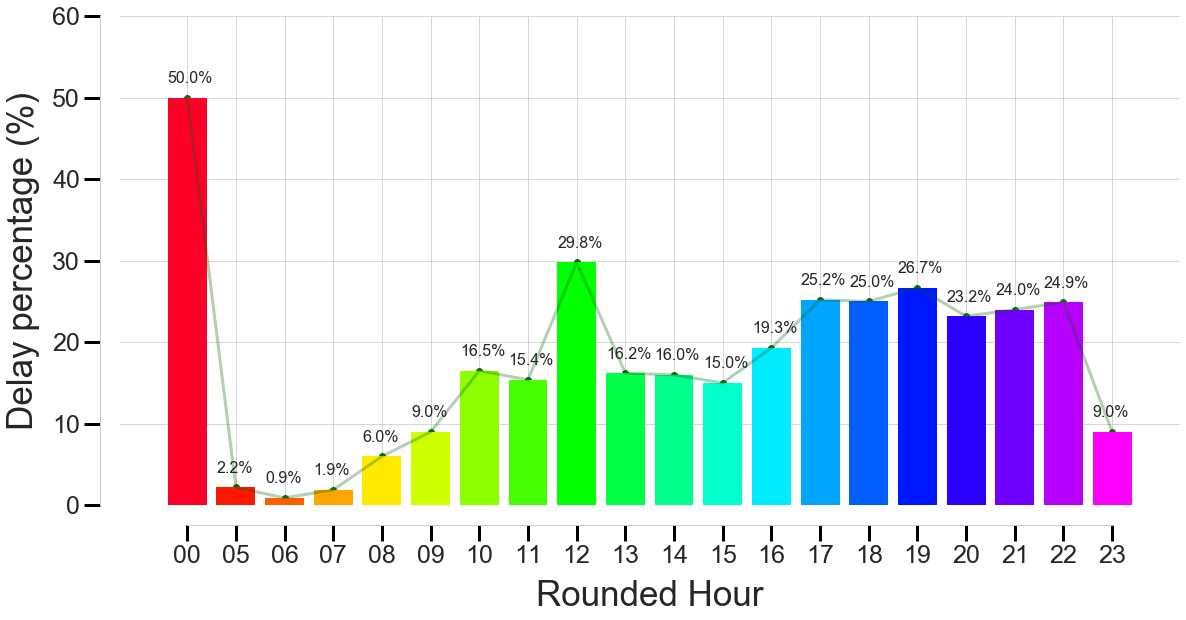

In [64]:
train_time = train[["Date_time","Delay.Indicator"]]
## round the whole time object up tl hour
train_time["Round_time"] = train_time["Date_time"].dt.round("H")
train_time["Round_Hour"] = train_time["Round_time"].apply(lambda x: x.strftime("%H"))

train_time = train_time[["Round_Hour","Delay.Indicator"]]
train_time = train_time.groupby("Round_Hour").mean().reset_index()
train_time['Round_Hour'] = train_time['Round_Hour'].astype('object')


fig, ax = plt.subplots(1,1,figsize=(19,9))
NUM_COLORS = 20
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

Hour_str = np.unique(train_time['Round_Hour'])
Hour = [i for i in range(20)]
Indicator = list(train_time["Delay.Indicator"].apply(lambda x: round(x*100,1)))

ax.set_xticks(Hour)
ax.set_xticklabels(Hour_str)

ax.spines['bottom'].set_bounds(0,19)
ax.bar(Hour,Indicator,color = colors)
ax.plot(Hour,Indicator,alpha = 0.3,color = 'darkgreen',linewidth = "3")
ax.scatter(Hour,Indicator,alpha = 0.9,color = 'darkgreen')
for p in ax.patches:
        percentage = '{}%'.format(p.get_height())
        x = p.get_x()
        y = p.get_y() + p.get_height()+1.8
        ax.annotate(percentage, (x, y),size = 16)


ax.tick_params(axis= "x",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.tick_params(axis= "y",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.set_yticks([i for i in range(0,61,10)])
ax.set_ylabel("Delay percentage (%)",size = 35,labelpad=12)
ax.set_xlabel("Rounded Hour",size = 35,labelpad=12)
adjust_spines(ax, ['left', 'bottom'])

#### Visualization of Weekend to the response

Weekend indicator is of interest because given the huge dataset, the distribution of the target is different by Weekend indicator

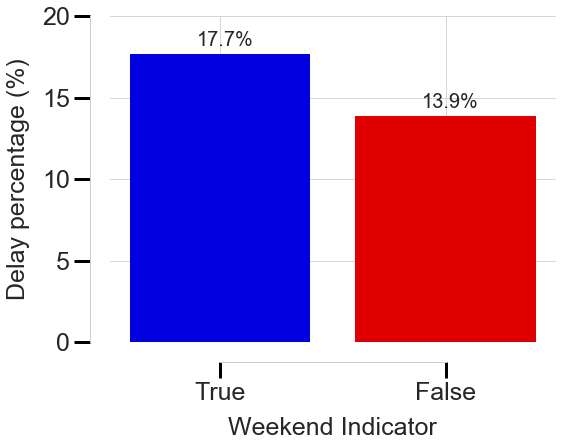

In [65]:
train_week = train[["weekend.Indicator","Delay.Indicator"]]
train_week = train_week.groupby("weekend.Indicator").mean().reset_index()
train_week['weekend.Indicator'] = train_week['weekend.Indicator'].astype('object')

fig, ax = plt.subplots(1,1,figsize=(8,6))

colors = ["#0101DF", "#DF0101"]
weekend = ["True","False"]
Indicator = list(train_week["Delay.Indicator"].apply(lambda x: round(100*x,1)))
ax.bar(weekend,Indicator,color = colors)

for p in ax.patches:
        percentage = '{}%'.format(p.get_height())
        x = p.get_x() + p.get_width()/2.7 
        y = p.get_y() + p.get_height()+0.5
        ax.annotate(percentage, (x, y),size = 20)

        
Week = [0,1]       
Week_str = ["True","False"]
ax.set_xticks(Week)
ax.set_xticklabels(Week_str)

ax.spines['bottom'].set_bounds(0,1)        
        
ax.tick_params(axis= "x",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.tick_params(axis= "y",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.set_xlabel("Weekend Indicator",size = 25,labelpad=12)
ax.set_ylabel("Delay percentage (%)",size = 25,labelpad=12)
ax.set_yticks([i for i in range(0,21,5)])
adjust_spines(ax, ['left', 'bottom'])

#### Visualization of Holiday to the response

Holiday indicator is of interest because given the huge dataset, the distribution of the target is different by Holiday indicator.

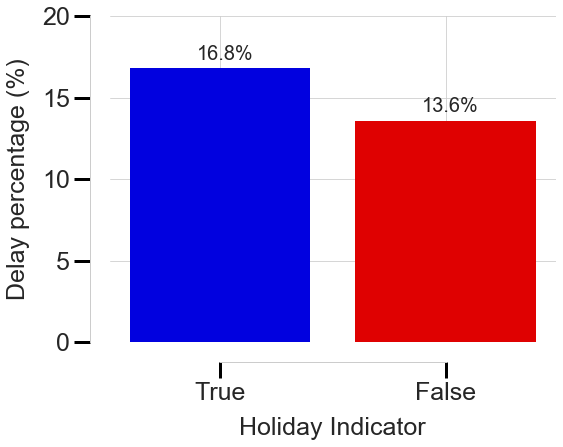

In [66]:
train_holiday = train[["holidays_indicator","Delay.Indicator"]]
train_holiday = train_holiday.groupby("holidays_indicator").mean().reset_index()
train_holiday['holidays_indicator'] = train_holiday['holidays_indicator'].astype('object')

fig, ax = plt.subplots(1,1,figsize=(8,6))

colors = ["#0101DF", "#DF0101"]
holiday = ["True","False"]
Indicator = list(train_holiday["Delay.Indicator"].apply(lambda x: round(100*x,1)))
ax.bar(holiday,Indicator,color = colors)

for p in ax.patches:
        percentage = '{}%'.format(p.get_height())
        x = p.get_x() + p.get_width()/2.7 
        y = p.get_y() + p.get_height()+0.5
        ax.annotate(percentage, (x, y),size = 20)

Holi = [0,1]       
Holi_str = ["True","False"]
ax.set_xticks(Holi)
ax.set_xticklabels(Holi_str)

ax.spines['bottom'].set_bounds(0,1)     
        
ax.tick_params(axis= "x",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.tick_params(axis= "y",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.set_xlabel("Holiday Indicator",size = 25,labelpad=12)
ax.set_ylabel("Delay percentage (%)",size = 25,labelpad=12)
ax.set_yticks([i for i in range(0,21,5)])
adjust_spines(ax, ['left', 'bottom'])

#### Visualization of number of daily sailings against delay frequency

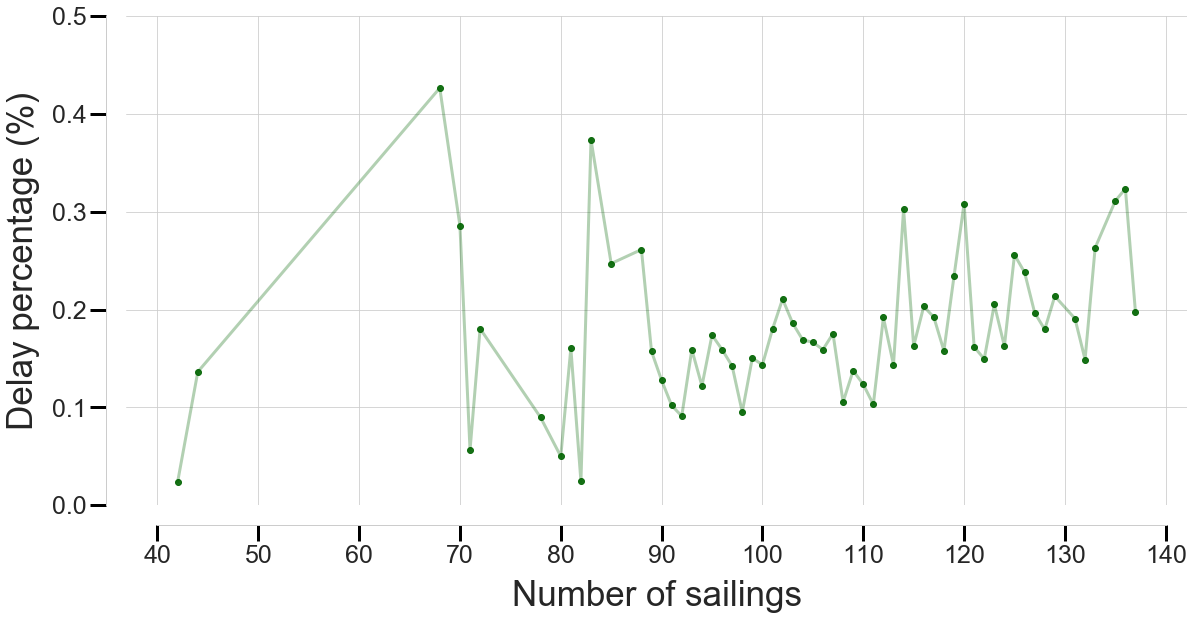

In [77]:
train_sa = train[["Num.of.sailings","Delay.Indicator"]]


train_sail = train_sa.groupby("Num.of.sailings").mean().reset_index()


fig, ax = plt.subplots(1,1,figsize=(19,9))


sailings = train_sail["Num.of.sailings"]
delay = train_sail["Delay.Indicator"]

ax.plot(sailings,delay,alpha = 0.3,color = 'darkgreen',linewidth = "3")
ax.scatter(sailings,delay,alpha = 0.9,color = 'darkgreen')



ax.tick_params(axis= "x",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.tick_params(axis= "y",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.set_xticks([i for i in range(40,150,10)])
ax.set_yticks([0.1*i for i in range(0,6)])
ax.set_ylabel("Delay percentage (%)",size = 35,labelpad=12)
ax.set_xlabel("Number of sailings",size = 35,labelpad=12)
adjust_spines(ax, ['left', 'bottom'])

## Vancouver

Temperature is associated with Dew.point and Temperatrure is also somewhat correlated with Relative.Humidity.

In [78]:
vancouver.drop("Humidex",axis=1,inplace = True)

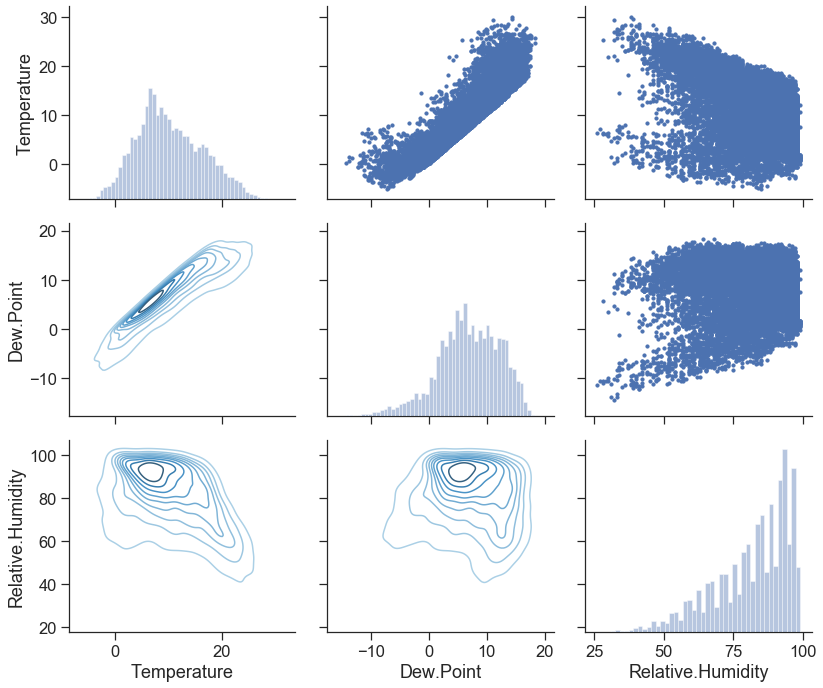

In [79]:
## pairplot
sns.set(style = "ticks", rc={'figure.figsize':(10,10),"xtick.major.size": 8, "ytick.major.size": 8},font_scale = 1.5)
vancouver["Month"] = vancouver["Year"].astype('object')

whe_dat = vancouver.loc[:,["Temperature","Dew.Point","Relative.Humidity"]]

g = sns.PairGrid(whe_dat, palette=["red"],height = 3.3,aspect = 1.2)

g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

## Victoria

InterpolateQuadratic_Tem is correlated with InterpolateQuadratic_Dew and InterpolateQuadratic_Humi

In [81]:
victoria.reset_index(inplace = True)

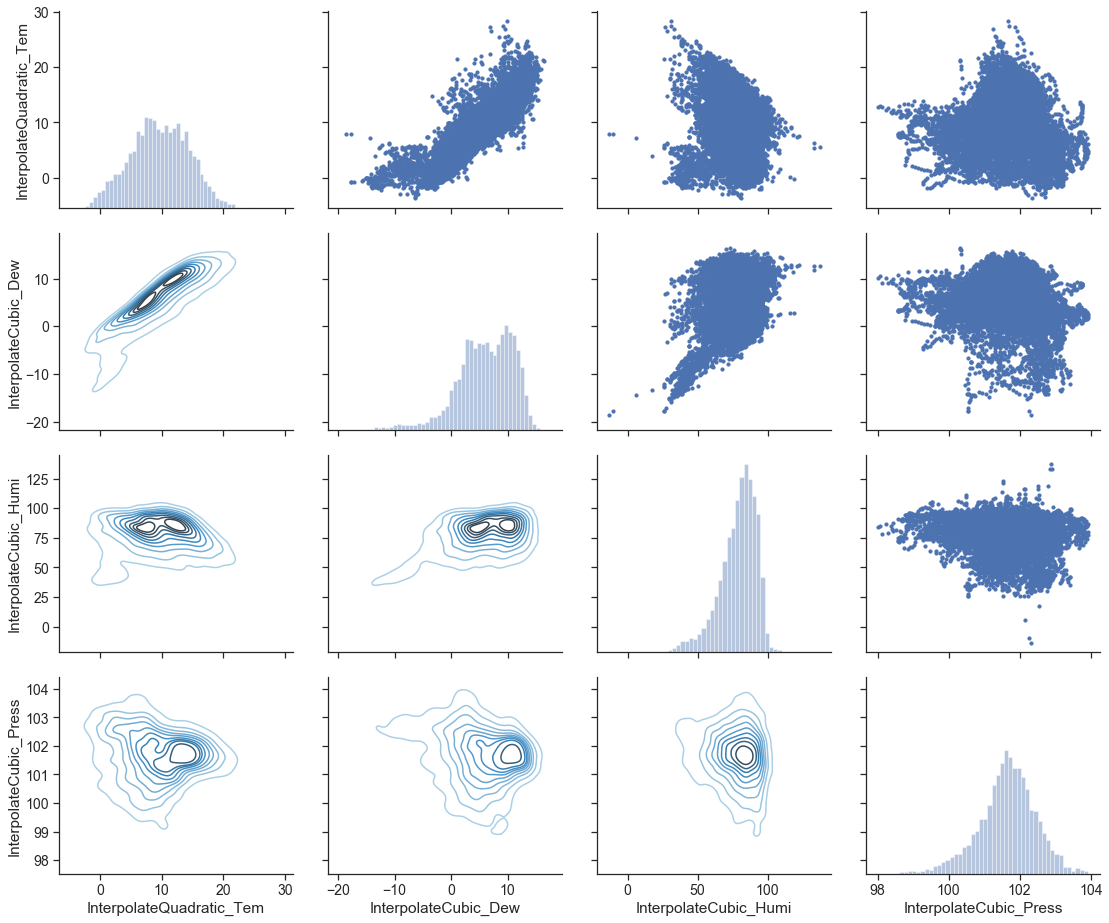

In [82]:
## pairplot
sns.set(style = "ticks", rc={'figure.figsize':(15,15)},font_scale = 1.28)
whe_dat = victoria.iloc[:,[7,9,10,11]]
whe_dat.dropna(axis =0,inplace = True)
g = sns.PairGrid(whe_dat, palette=["red"],height = 3.3,aspect = 1.2)

g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

# Feature seletion

## Vancouver

In [85]:
## temperature lags
vancouver['van_tem_lag1'] = vancouver['Temperature'].shift(1)
vancouver['van_tem_lag2'] = vancouver['Temperature'].shift(2)

## Dew.Point lags
vancouver['van_dew_lag1'] = vancouver['Dew.Point'].shift(1)
vancouver['van_dew_lag2'] = vancouver['Dew.Point'].shift(2)

## Relative.Humidity lags
vancouver['van_hum_lag1'] = vancouver['Relative.Humidity'].shift(1)
vancouver['van_hum_lag2'] = vancouver['Relative.Humidity'].shift(2)

In [86]:
vancouver.dropna(axis=0,inplace=True)

In [87]:
## Extract the datetime rounded to hour 
train["Round_time"] = train["Date_time"].dt.round("H")
test["Round_time"] = test["Date_time"].dt.round("H")

In [88]:
vancouver_merge = vancouver.iloc[:,[0,5,6,7,12,13,14,15,16,17]]

In [89]:
train.set_index("Round_time",inplace = True)
vancouver_merge.set_index("Date.Time",inplace =True)
train1 = train.merge(vancouver_merge,left_index = True, right_index = True,how = "left")

In [90]:
test.set_index("Round_time",inplace = True)
test1 = test.merge(vancouver_merge,left_index = True, right_index = True,how = "left")

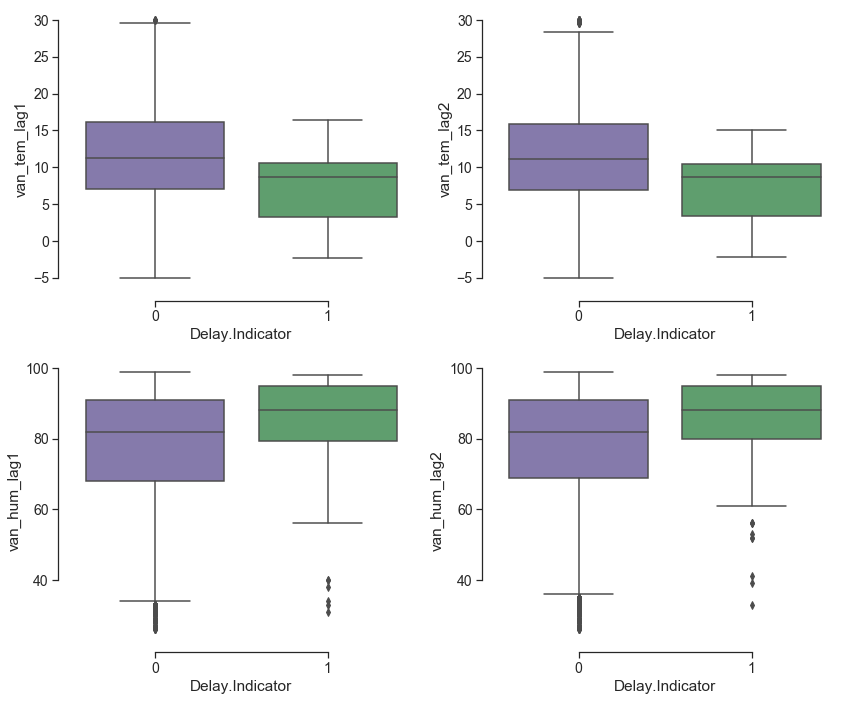

In [91]:
fig,axes = plt.subplots(2,2,figsize=(12,10))

sns.boxplot(x="Delay.Indicator", y="van_tem_lag1",
             palette=["m", "g"],
            data=train1.loc[train1.Status.isin(["On Time","Weather delay"])],ax = axes[0,0])
sns.boxplot(x="Delay.Indicator", y="van_tem_lag2",
             palette=["m", "g"],
            data=train1.loc[train1.Status.isin(["On Time","Weather delay"])],ax = axes[0,1])
sns.boxplot(x="Delay.Indicator", y="van_hum_lag1",
             palette=["m", "g"],
            data=train1.loc[train1.Status.isin(["On Time","Weather delay"])],ax = axes[1,0])
sns.boxplot(x="Delay.Indicator", y="van_hum_lag2",
             palette=["m", "g"],
            data=train1.loc[train1.Status.isin(["On Time","Weather delay"])],ax = axes[1,1])

sns.despine(offset=10, trim=True)

plt.tight_layout()

## Victoria

Visualizing the correlation between vic_tem_lag1 and delay frequency.

In [92]:
victoria.dropna(axis=0,inplace = True)

In [93]:
## temperature lags
victoria['vic_tem_lag1'] = victoria['InterpolateQuadratic_Tem'].shift(1)
victoria['vic_tem_lag2'] = victoria['InterpolateQuadratic_Tem'].shift(2)

## Dew.Point lags
victoria['vic_dew_lag1'] = victoria['InterpolateCubic_Dew'].shift(1)
victoria['vic_dew_lag2'] = victoria['InterpolateCubic_Dew'].shift(2)

## Relative.Humidity lags
victoria['vic_hum_lag1'] = victoria['InterpolateCubic_Humi'].shift(1)
victoria['vic_hum_lag2'] = victoria['InterpolateCubic_Humi'].shift(2)

## press lags
victoria['vic_press_lag1'] = victoria['InterpolateCubic_Press'].shift(1)
victoria['vic_press_lag2'] = victoria['InterpolateCubic_Press'].shift(2)

In [94]:
victoria.dropna(axis=0,inplace=True)

In [95]:
victoria_merge = victoria.iloc[:,[0,7,9,10,11,12,13,14,15,16,17,18,19]]

In [96]:
victoria_merge.set_index("Date.Time",inplace = True)
train1 = train1.merge(victoria_merge,left_index = True, right_index = True,how = "left")

In [97]:
test1 = test1.merge(victoria_merge,left_index = True, right_index = True,how = "left")

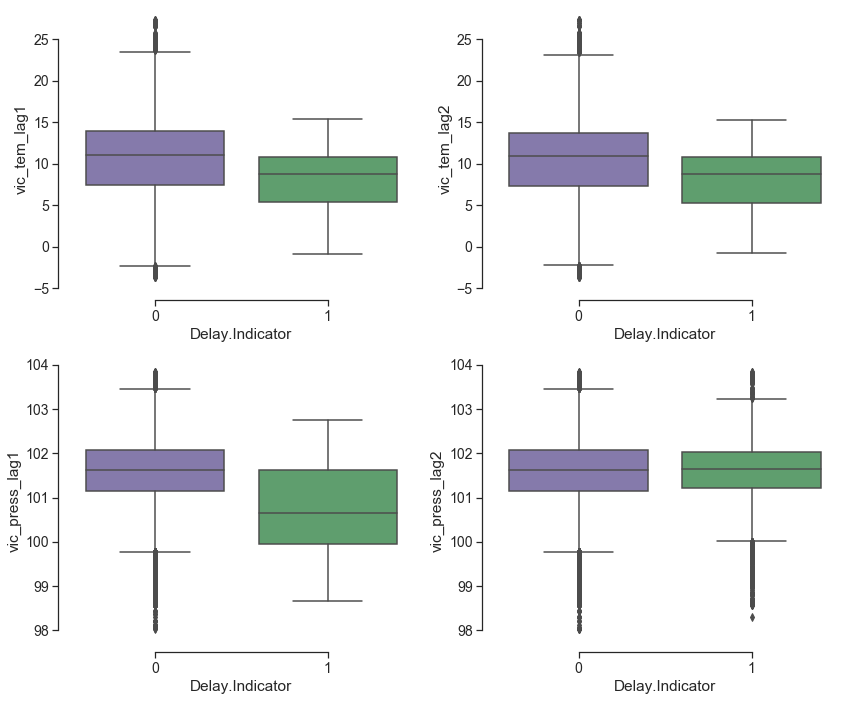

In [98]:
fig,axes = plt.subplots(2,2,figsize=(12,10))

sns.boxplot(x="Delay.Indicator", y="vic_tem_lag1",
             palette=["m", "g"],
            data=train1.loc[train1["Status"].isin(["On Time","Weather delay"])],ax = axes[0,0])
sns.boxplot(x="Delay.Indicator", y="vic_tem_lag2",
             palette=["m", "g"],
            data=train1.loc[train1["Status"].isin(["On Time","Weather delay"])],ax = axes[0,1])
sns.boxplot(x="Delay.Indicator", y="vic_press_lag1",
             palette=["m", "g"],
            data=train1.loc[train1["Status"].isin(["On Time","Weather delay"])],ax = axes[1,0])
sns.boxplot(x="Delay.Indicator", y="vic_press_lag2",
             palette=["m", "g"],
            data=train1,ax = axes[1,1])

sns.despine(offset=10, trim=True)

plt.tight_layout()


## Traffic

In [101]:
traffic["Date"] = pd.to_datetime(traffic["Date"])
traffic.set_index("Date",inplace=True)

### Extracting the traffic features

#### traffic mean at an interval of 10 mins

In [102]:
## feature extration for train traffic mean
train["lag1"] = train["Date_time"].apply(lambda x:lag1_mean(x))
train["lag2"] = train["Date_time"].apply(lambda x:lag2_mean(x))
train["lag3"] = train["Date_time"].apply(lambda x:lag3_mean(x))
train["lag4"] = train["Date_time"].apply(lambda x:lag4_mean(x))

## feature extration for test traffic mean
test1["lag1"] = test1["Date_time"].apply(lambda x:lag1_mean(x))
test1["lag2"] = test1["Date_time"].apply(lambda x:lag2_mean(x))
test1["lag3"] = test1["Date_time"].apply(lambda x:lag3_mean(x))
test1["lag4"] = test1["Date_time"].apply(lambda x:lag4_mean(x))

In [103]:
## feature extration for train traffic standard deviation
train["lag_std1"] = train["Date_time"].apply(lambda x:lag1_sd(x))
train["lag_std2"] = train["Date_time"].apply(lambda x:lag2_sd(x))
train["lag_std3"] = train["Date_time"].apply(lambda x:lag3_sd(x))

## feature extration for test traffic standard deviation
test1["lag_std1"] = test1["Date_time"].apply(lambda x:lag1_sd(x))
test1["lag_std2"] = test1["Date_time"].apply(lambda x:lag2_sd(x))
test1["lag_std3"] = test1["Date_time"].apply(lambda x:lag3_sd(x))

#### traffic standard deviation at an interval of 10 mins

In [104]:
# indeces of missing values
lag_in_1 = train.loc[train["lag1"].isna(),:].index
lag_in_2 = train.loc[train["lag4"].isna(),:].index
lag_index_std = train.loc[train["lag_std1"].isna(),:].index

In [105]:
## Since lag1 and lag2 before 7:25 are 1.0, we decided to impute all mising lag1 and lag2 with 1.0
train.loc[lag_in_1,"lag1"] = 1.0
train.loc[lag_in_1,"lag2"] = 1.0
train.loc[lag_in_1,"lag3"] = 1.0
train.loc[lag_in_2,'lag4'] = 1.0

train.loc[lag_index_std,"lag_std1"] = 0
train.loc[lag_index_std,"lag_std2"] = 0
train.loc[lag_index_std,"lag_std3"] = 0

train["Delay.Indicator"] = train["Delay.Indicator"].astype('category')

In [106]:
train["log_lag1"] = np.log(train["lag1"])
train["log_lag2"] = np.log(train["lag2"])
train["log_lag3"] = np.log(train["lag3"])
train["log_lag4"] = np.log(train["lag4"])

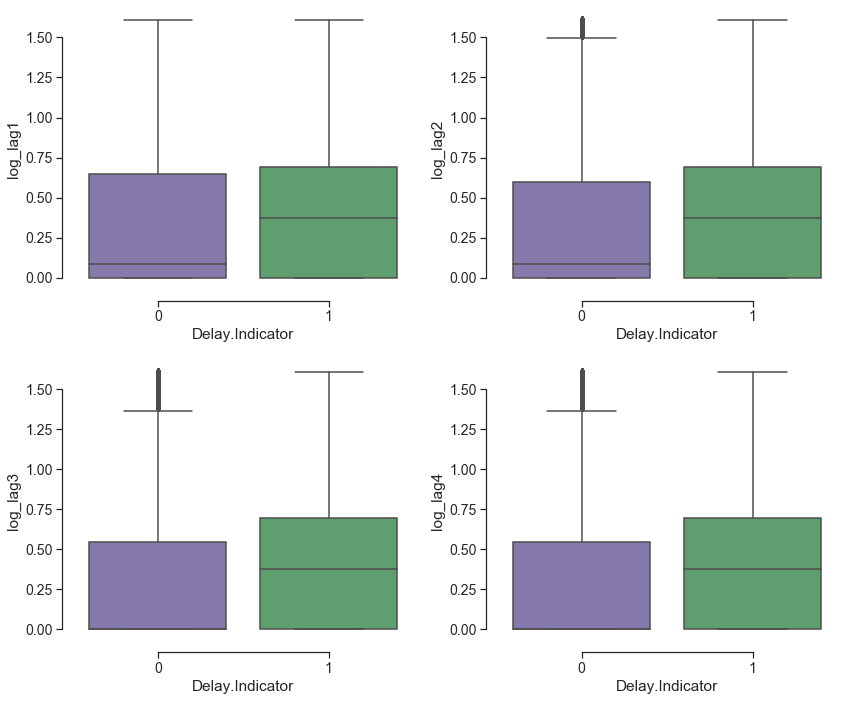

In [107]:
fig,axes = plt.subplots(2,2,figsize=(12,10))

sns.boxplot(x="Delay.Indicator", y="log_lag1",
             palette=["m", "g"],
            data=train.loc[train["Status"].isin(["On Time","Traffic delay"])],ax = axes[0,0])
sns.boxplot(x="Delay.Indicator", y="log_lag2",
             palette=["m", "g"],
            data=train.loc[train["Status"].isin(["On Time","Traffic delay"])],ax = axes[0,1])
sns.boxplot(x="Delay.Indicator", y="log_lag3",
             palette=["m", "g"],
            data=train.loc[train["Status"].isin(["On Time","Traffic delay"])],ax = axes[1,0])
sns.boxplot(x="Delay.Indicator", y="log_lag4",
             palette=["m", "g"],
            data=train.loc[train["Status"].isin(["On Time","Traffic delay"])],ax = axes[1,1])

sns.despine(offset=10, trim=True)

plt.tight_layout()

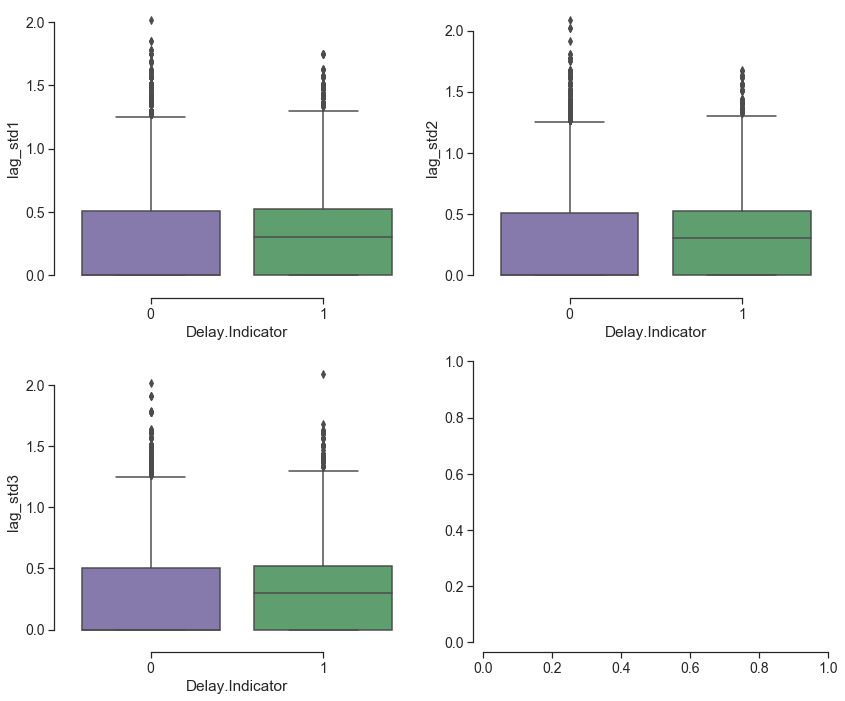

In [108]:
fig,axes = plt.subplots(2,2,figsize=(12,10))

sns.boxplot(x="Delay.Indicator", y="lag_std1",
             palette=["m", "g"],
            data=train,ax = axes[0,0])
sns.boxplot(x="Delay.Indicator", y="lag_std2",
             palette=["m", "g"],
            data=train,ax = axes[0,1])
sns.boxplot(x="Delay.Indicator", y="lag_std3",
             palette=["m", "g"],
            data=train,ax = axes[1,0])


sns.despine(offset=10, trim=True)

plt.tight_layout()

# Save data

In [109]:
train.to_csv(r"C:\Users\xfu3\Desktop\Ferry project\traffic_clean3.csv", index = True)

In [110]:
test1.to_csv(r"C:\Users\xfu3\Desktop\Ferry project\test_clean3.csv", index = True)

In [111]:
## Final
train1.to_csv(r"C:\Users\xfu3\Desktop\Ferry project\train3.csv", index = True)